# Forecasting σ(r) vs Observation Time

This notebook estimates the uncertainty on the tensor-to-scalar ratio, $\sigma(r)$, as a function of observation time for a CMB experiment like Simons Observatory. 
It uses per-band NETs and foreground modeling via `fgbuster`.

*Author: SciPol project – CNRS / APC*


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
import camb
from camb import model, initialpower
from fgbuster import MixingMatrix, CMB, Dust, Synchrotron
import pylab as pl

In [32]:
deg2rad = np.pi / 180
arcmin2sr = (deg2rad / 60)**2

def NET_to_uK_arcmin(NET_uKsqrtsec, N_det, t_obs_years, fsky, efficiency):
    t_obs_sec = t_obs_years * 365.25 * 24 * 3600 * efficiency
    area_sr = 4 * np.pi * fsky
    area_arcmin2 = area_sr / arcmin2sr
    uK_arcmin = []
    for NET, ndet in zip(NET_uKsqrtsec, N_det):
        sigma_pix = NET / np.sqrt(ndet * t_obs_sec)
        noise = sigma_pix * np.sqrt(area_arcmin2)
        uK_arcmin.append(noise)
    return uK_arcmin

In [33]:
def generate_theory_cls_with_camb(lmax=3000):
    pars_r1 = camb.CAMBparams()
    pars_r1.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
    pars_r1.InitPower.set_params(As=2e-9, ns=0.965, r=1.0)
    pars_r1.set_for_lmax(lmax, lens_potential_accuracy=1)
    pars_r1.WantTensors = True
    results_r1 = camb.get_results(pars_r1)
    cls_r1 = results_r1.get_cmb_power_spectra(pars_r1, CMB_unit='muK', lmax=lmax)
    cl_bb_r1 = cls_r1['tensor'][2:, 2]

    pars_lens = camb.CAMBparams()
    pars_lens.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
    pars_lens.InitPower.set_params(As=2e-9, ns=0.965, r=0.0)
    pars_lens.set_for_lmax(lmax, lens_potential_accuracy=1)
    pars_lens.WantTensors = False
    results_lens = camb.get_results(pars_lens)
    cls_lens = results_lens.get_cmb_power_spectra(pars_lens, CMB_unit='muK', lmax=lmax)
    cl_bb_lens = cls_lens['lensed_scalar'][2:, 2]

    ell_cls = np.arange(2, lmax + 1)
    norm = ell_cls*(ell_cls+1)/2/np.pi
    return ell_cls, cl_bb_r1/norm, cl_bb_lens/norm

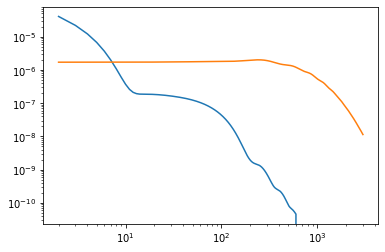

In [34]:
a = generate_theory_cls_with_camb(lmax=3000)
pl.loglog(a[0], a[1]*1e-3)
pl.loglog(a[0], a[2])
pl.show()

In [35]:
def simulate_noise_spectra_multiband(ell, config):
    """
    Simulate N_ell for each band with its own white noise, alpha, and ell_knee.
    config = list of dicts with keys: freq, N_white, alpha, ell_knee
    Returns: dict {freq: N_ell}
    """
    noise_dict = {}
    for band in config:
        N_white = band['N_white']  # in μK².arcmin, convert to μK².rad
        alpha = band['alpha']
        ell_knee = band['ell_knee']
        N_white_rad = (N_white * np.pi / (180 * 60))**2
        residual = N_white_rad * (ell_knee / (ell + 1e-3))**alpha
        N_ell = N_white_rad + residual
        W_ell = beam_window_function(ell, band['beam_fwhm'])
        noise_dict[band['freq']] = N_ell/W_ell**2
    return noise_dict

In [40]:
def beam_window_function(ell, fwhm_arcmin):
    """Gaussian beam window function."""
    sigma_rad = (fwhm_arcmin / np.sqrt(8 * np.log(2))) * deg2rad / 60
    return np.exp(-ell * (ell + 1) * sigma_rad**2)

In [36]:
def get_mixing_matrix(frequencies, T_dust=19.6, beta_d=1.54, beta_s=-3.0):
    """
    Create fgbuster mixing matrix with CMB, dust and synchrotron.
    Frequencies in GHz.
    """
    components = [
        CMB(),
        Dust(150., temp=T_dust, beta_d=beta_d),
        Synchrotron(30., beta_pl=beta_s)
    ]
    A = MixingMatrix(*components)
    return  A.evaluator(np.array(frequencies))()  # shape (n_freq, n_comp)

In [37]:
def compute_effective_noise_multicomponent(ell, noise_dict, mixing_matrix, comp_index=0):
    """
    Combine multi-band noise through projection onto CMB component.
    mixing_matrix: shape (n_freq, n_comp)
    """
    n_freq, n_comp = mixing_matrix.shape
    freqs = list(noise_dict.keys())
    assert len(freqs) == n_freq

    N_ell_matrix = np.array([noise_dict[freq] for freq in freqs])  # shape (n_freq, n_ell)
    N_eff = []
    
    for i in range(len(ell)):
        N_cov = np.diag(N_ell_matrix[:, i])  # diagonal, uncorrelated noise
        A = mixing_matrix
        AtNiA = A.T @ np.linalg.inv(N_cov) @ A
        N_proj = np.linalg.inv(AtNiA)[comp_index, comp_index]  # [0,0] is CMB component
        N_eff.append(N_proj)
        
    return np.array(N_eff)

In [38]:
def compute_fisher_sigma_r(ell, cl_r1, cl_lens, N_ell_eff, include_alens=True):
    valid = (ell >= 30) & (ell <= 300)
    ell = ell[valid]
    C_ell = cl_r1[valid] * 0.01 + cl_lens[valid] + N_ell_eff[valid]
    dCl_dr = cl_r1[valid]
    dCl_dAlens = cl_lens[valid] if include_alens else None
    param_list = ['r']
    derivs = [dCl_dr]
    if include_alens:
        param_list.append('Alens')
        derivs.append(dCl_dAlens)
    nparams = len(param_list)
    F = np.zeros((nparams, nparams))
    for i in range(nparams):
        for j in range(nparams):
            F[i, j] = np.sum((2 * ell + 1) * derivs[i] * derivs[j] / (2 * C_ell)**2)
    cov = np.linalg.inv(F)
    r_index = param_list.index('r')
    return np.sqrt(cov[r_index, r_index])

In [42]:
def compute_fisher_matrix(ell, cl_r1, cl_lens, n_ell_bb, 
                          ell_min=30, ell_max=300, fsky=0.1, true_r=0.0,
                          include_alens=True, true_Al=1.0, extra_templates=None):
    """
    Compute Fisher matrix for r and optionally Alens and other templates.
    extra_templates: list of (name, dCl_dparam) derivatives of C_ell^BB
    """
    N_ell_eff = n_ell_bb * 1.0
    valid = (ell >= ell_min) & (ell <= ell_max)
    ell = ell[valid]
    
    # C_ell = np.outer(np.ones_like(ell), cl_lens[valid]) + np.outer(np.ones_like(ell), cl_r1[valid]) * 0.00 + N_ell_eff[valid]
    C_ell = cl_lens[valid] * true_Al + N_ell_eff[valid] +  cl_r1[valid] * true_r
    
    # Derivatives
    dCl_dr = cl_r1[valid]
    dCl_dAlens = cl_lens[valid] if include_alens else None
    
    # Fisher matrix
    param_list = ['r']
    derivs = [dCl_dr]
    
    if include_alens:
        param_list.append('Alens')
        derivs.append(dCl_dAlens)
        
    if extra_templates:
        for name, dCl in extra_templates:
            param_list.append(name)
            derivs.append(dCl[valid])
    
    nparams = len(param_list)
    F = np.zeros((nparams, nparams))
    
    for i in range(nparams):
        for j in range(nparams):
            dCi = derivs[i]
            dCj = derivs[j]
            F[i, j] = np.sum((2 * ell + 1) * fsky * dCi * dCj / (2 * C_ell)**2)

    return F, param_list

def estimate_sigma_r(fisher_matrix, param_list):
    """Return marginalized sigma(r) from Fisher matrix."""
    cov = inv(fisher_matrix)
    r_index = param_list.index('r')
    return np.sqrt(cov[r_index, r_index])

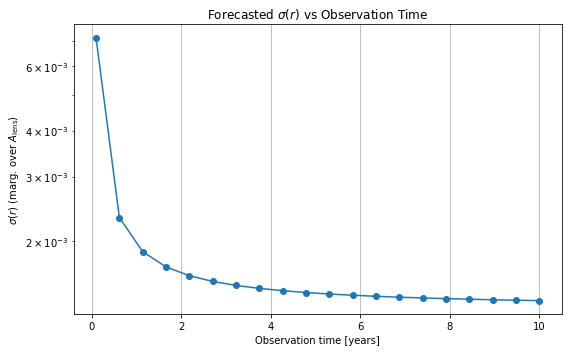

In [43]:
times = np.linspace(0.1, 10, 20)
fsky = 0.1
freqs = [27, 39, 93, 145, 225, 280]
NETs = [21, 13, 3.4, 4.3, 8.6, 22] # uK.rs per tube 
Ndets = [1,1,2,2,1,1]# actual number of tubes ... #[3500, 3500, 6000, 6000, 2000, 1000]
ell = np.arange(30, 300)
ell_knees = [40, 50, 20, 30, 40, 50]
alphas = [3.0, 2.7, 2.4, 2.6, 3.0, 3.2]
beam_fwhm = [91., 63., 30., 17., 11., 9.]
true_Al = 0.5
efficiency = 0.8 
true_r=0.
ell_min,ell_max= 30,300

ell_cls, cl_r1_raw, cl_lens_raw = generate_theory_cls_with_camb()
cl_r1 = np.interp(ell, ell_cls, cl_r1_raw)
cl_lens = np.interp(ell, ell_cls, cl_lens_raw)

A = get_mixing_matrix([band for band in freqs])

sigma_r_list = []

for t in times:
    uK_arcmin = NET_to_uK_arcmin(NETs, Ndets, t_obs_years=t, fsky=fsky, efficiency=efficiency)
    config = [{"freq": freqs[i],  "N_white": uK_arcmin[i], "alpha": alphas[i], "ell_knee": ell_knees[i], "beam_fwhm":beam_fwhm[i]} for i in range(len(freqs))]
    noise_dict = simulate_noise_spectra_multiband(ell, config)
    N_ell_eff = compute_effective_noise_multicomponent(ell, noise_dict, A, comp_index=0)
    F, params = compute_fisher_matrix(ell, cl_r1, cl_lens, N_ell_eff, 
                      ell_min=ell_min, ell_max=ell_max, fsky=fsky, true_r=true_r,
                      include_alens=True, true_Al=1.0, extra_templates=None)
    sigma_r_list.append( estimate_sigma_r(F, params) )


pl.figure(figsize=(8, 5))
pl.plot(times, sigma_r_list, marker='o')
pl.xlabel("Observation time [years]")
pl.ylabel(r"$\sigma(r)$ (marg. over $A_\mathrm{lens}$)")
pl.yscale("log")
pl.grid(True)
pl.title("Forecasted $\sigma(r)$ vs Observation Time")
pl.tight_layout()
pl.show()
